In [1]:
from collections import defaultdict
from functools import partial, reduce
from itertools import chain
from matplotlib import pyplot as plt
import numpy as np
from operator import add
import pandas as pd
from scipy import stats
import scipy.signal
from scipy.optimize import curve_fit, minimize
from scipy.special import gammaln
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [2]:
MAX_DIST = 0.3
MIN_OCCUPANCY = 0.1
FIRST_CHAIN = 198

In [3]:
def sigmoid(x, x_0, k):
    return 1 / (1 + np.exp(-k * (x - x_0)))

def get_pair(num, first_chain_len=FIRST_CHAIN):
    f = num %  first_chain_len
    s = num // first_chain_len
    return (f + 1, s + 1)

In [750]:
PREFIX = "/data/analytics/catch_bonds/1sq0/dists_max_chains/"
last_frame_dist_dict = defaultdict(list)
mean_dist_dict = defaultdict(list)
std_dist_dict = defaultdict(list)
com_dists = np.zeros((10, 21, 1000))

for rep in range(1, 11):
    for force in np.arange(0, 2.1, .1):
        force_str = str(int(force)) if force == int(force) else str(force)
        filename = "{}/{}_{}.xvg".format(PREFIX, rep, force_str)
        dists_df = pd.read_csv(filename, skiprows=24, header=None, sep="\s+", engine="python")
        dists_df.columns = ["frame", "max_dist"]

        mean_dist_dict[int(force * 10)].append(dists_df.max_dist.mean())
        std_dist_dict[int(force * 10)].append(dists_df.max_dist.std())
        last_frame_dist_dict[int(force * 10)].append(dists_df.max_dist.iloc[-1])
        
#         com_dists[rep - 1, int(force * 10)] = dists_df.max_dist.values

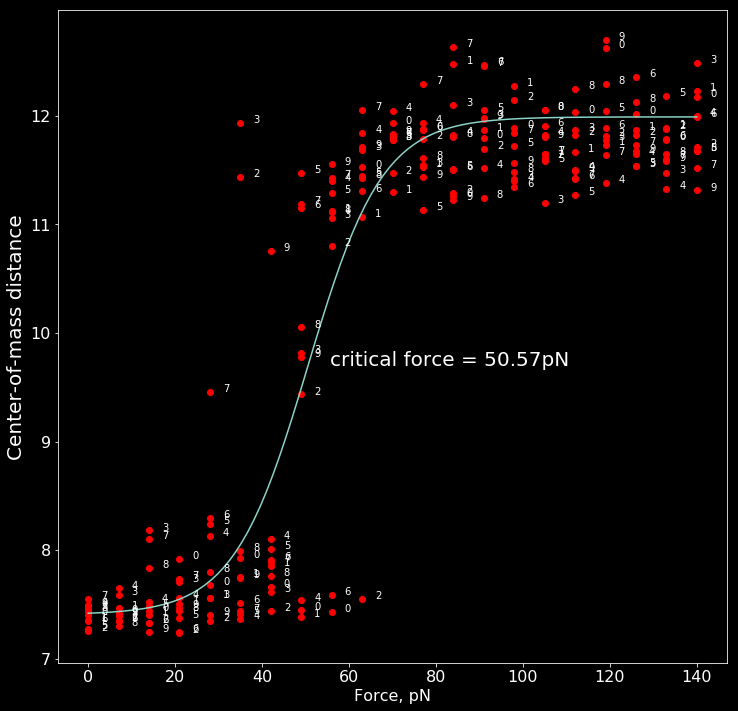

In [751]:
fig = plt.figure(figsize=(12, 12))
plt.style.use('dark_background')
fig.patch.set_facecolor("xkcd:black")
ax = fig.add_subplot(1, 1, 1)

for k, v in last_frame_dist_dict.items():
    ax.plot([k * 7] * len(v), v, "ro", alpha=1)
    for i, vv in enumerate(v):
        ax.text(k * 7 + 3, vv, str(i))
    
xdata, ydata = zip(*[(k, np.mean(v)) for k, v in last_frame_dist_dict.items()])
# xdata, ydata = for k, v in mean_dist_dict
xdata, ydata = np.array(xdata) * 7, np.array(ydata)
y_trans = MinMaxScaler()
ydata = y_trans.fit_transform(ydata[:, None])[:, 0]
popt, pcov = curve_fit(sigmoid, xdata, ydata, method="trf")

xs = np.linspace(0, 140, 100)
ys = sigmoid(xs, *popt)
    
[t.set_fontsize(16) for t in ax.get_xticklabels()]
ax.set_xlabel("Force, pN", fontdict={"size": 16})
[t.set_fontsize(16) for t in ax.get_yticklabels()]
ax.set_ylabel("Center-of-mass distance", fontdict={"size": 20})

ax.plot(xs, y_trans.inverse_transform(ys[:, None])[:, 0]);
ax.text(popt[0] + 5, 
        y_trans.inverse_transform([[0.5]]), 
        "critical force = {:.2f}pN".format(popt[0]), fontdict={"size": 20});

We can see here that under force 49pN repetitions 2, 3, 8 and 9 seem 'intermediate', however a close look to trajectroies disclose that these simulations just need more time to make proteins dissociate.

We would like to build a classifier between associated (A), dissociated (D) and intermediate (I) state.  
Let's use SASA as the input feature and take a look to the distribution.

/home/analytics/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


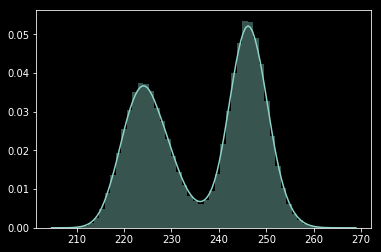

In [28]:
SASA_PREFIX = "/data/analytics/catch_bonds/1sq0/sasa_AB/"
sasa_ab_arr = np.zeros((10, 21, 1000))

for rep in range(1, 11):
    for force in np.arange(0, 2.1, .1):
        force_str = str(int(force)) if force == int(force) else str(force)
        filename = "{}/{}_{}.xvg".format(SASA_PREFIX, rep, force_str)
        dists_df = pd.read_csv(filename, skiprows=24, header=None, sep="\s+")
        dists_df.columns = ["frame", "SASA"]
        
        sasa_ab_arr[rep - 1, int(force * 10)] = dists_df.SASA.values
sns.distplot(sasa_ab_arr[:, :, :].flatten());

# First approximation

/home/analytics/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


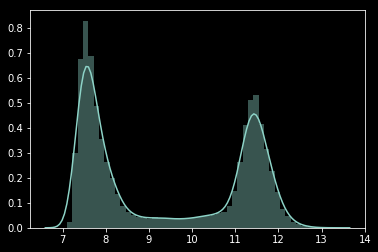

In [492]:
MAX_DIST_PREFIX = "/data/analytics/catch_bonds/1sq0/dists_max_chains/"
max_dist_arr = np.zeros((10, 21, 1000))

for rep in range(1, 11):
    for force in np.arange(0, 2.1, .1):
        force_str = str(int(force)) if force == int(force) else str(force)
        filename = "{}/{}_{}.xvg".format(MAX_DIST_PREFIX, rep, force_str)
        dists_df = pd.read_csv(filename, skiprows=24, header=None, sep="\s+")
        dists_df.columns = ["frame", "max_dist"]
        
        max_dist_arr[rep - 1, int(force * 10)] = dists_df.max_dist.values
sns.distplot(max_dist_arr[:, :, :].flatten());

max distance >= 10 nanometers, than they are dissociated.  
max distance <= 8 nm, than they are associated  
max distance >= 8 and <= 8.5, than intermediate  

Let's find a first approximation for SASA this way.

/home/analytics/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


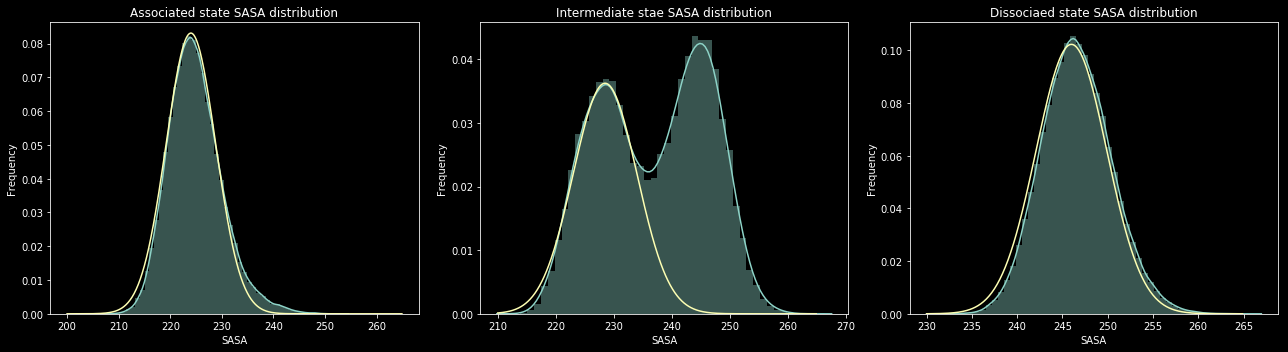

In [487]:
AI = 8
ID = 9

dissociated_part  = sasa_ab_arr[max_dist_arr > ID]
assocaited_part   = sasa_ab_arr[max_dist_arr < AI]
intermediate_part = sasa_ab_arr[(max_dist_arr > AI) & (max_dist_arr < ID)]

fig = plt.figure(figsize=(18, 5))

ax = fig.add_subplot(1, 3, 1)
sns.distplot(assocaited_part, ax=ax)
ax.set_title("Associated state SASA distribution")
ax.set_xlabel("SASA")
ax.set_ylabel("Frequency")

xs = np.arange(200, 265, .1)
# Several parameters tried by hand, those do fit.
ys = stats.norm(224, 4.8).pdf(xs)
ax.plot(xs, ys)

ax = fig.add_subplot(1, 3, 2)
sns.distplot(intermediate_part, ax=ax)
ax.set_title("Intermediate stae SASA distribution")
ax.set_xlabel("SASA")
ax.set_ylabel("Frequency")

xs = np.arange(210, 265, .1)
# Several parameters tried by hand, those do fit.
ys = .5 * stats.norm(228.5, 5.5).pdf(xs)
ax.plot(xs, ys)

ax = fig.add_subplot(1, 3, 3)
sns.distplot(dissociated_part, ax=ax)
ax.set_title("Dissociaed state SASA distribution")
ax.set_xlabel("SASA")
ax.set_ylabel("Frequency")

xs = np.arange(230, 265, .1)
# Several parameters tried by hand, those do fit.
ys = stats.norm(246, 3.9).pdf(xs)
ax.plot(xs, ys)

plt.tight_layout()

In [488]:
assocaited_part.shape[0] / 210000, \
intermediate_part.shape[0] / 210000, \
dissociated_part.shape[0] / 210000

(0.42374285714285714, 0.10012380952380952, 0.47576666666666667)

(200, 270)

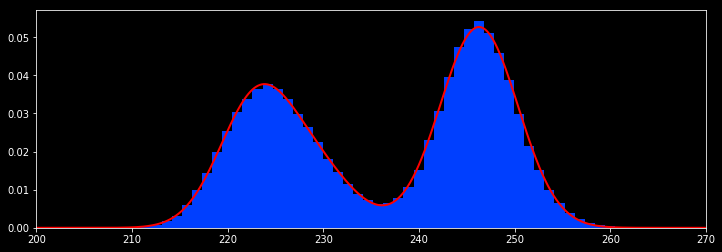

In [510]:
EPS = 1e-6

def negLogLikelihood(params, data):
    """the negative log-Likelohood-Function"""
    lnl = - np.sum(np.log(gauss(data, *params)))
    return lnl

def gauss(x, *args):
    assert (len(args) + 1) % 3 == 0
    
    n = (len(args) + 1) // 3
    alphas = list(args[-n+1:])
    assert np.sum(alphas) <= 1.
    
    alphas.append(1 - np.sum(alphas))
    args = args[:-n+1]
    mus, sigmas = args[::2], args[1::2]
    return np.concatenate(
        [alpha * stats.norm.pdf(x, mu, sigma)[:, None] for alpha, mu, sigma in zip(alphas, mus, sigmas)],
        axis=1
    ).sum(axis=1)

loss = partial(negLogLikelihood, data=sasa_ab_arr.flatten())
result = minimize(loss, [224, 4.8,
                         228.5, 5.5,
                         246, 3.9, 
                         
                         .423, .10], method='Nelder-Mead')

# loss = partial(negLogLikelihood, data=sasa_ab_arr.flatten())
# result = minimize(loss, [224, 5,
#                          229, 9.5,
#                          246, 3.9, 
                         
#                          .4237, .138], method='Nelder-Mead')


x_plot = np.linspace(0, 300, 3000)

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1, 1)
ax.hist(sasa_ab_arr.flatten(), bins=55, density=True)
ax.plot(x_plot, gauss(x_plot, *result.x), 'r-', lw=2)

ax.set_xlim(200, 270)

In [511]:
result.x

array([  2.22886452e+02,   3.85224983e+00,   2.29035134e+02,
         4.15763556e+00,   2.46277096e+02,   4.07702094e+00,
         3.08536461e-01,   1.52957283e-01])

# Visual evaluation of frames in intermediate state

In [19]:
whole_arr = np.load("/data/analytics/catch_bonds/1sq0/dists_npz/whole.npz")["arr_0"]
whole_arr.shape

(10, 21, 1000, 52470)

In [493]:
whole_contacts = whole_arr <= .8
contacts_counts = whole_contacts.sum(axis=3)
contact_indices = np.where(whole_contacts)

In [497]:
sns.set_palette("bright")

/home/analytics/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 864x864 with 0 Axes>

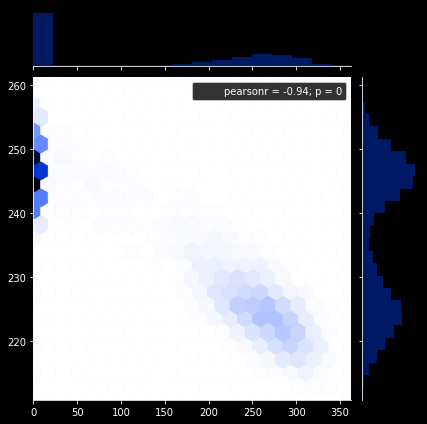

In [498]:
idx = np.random.choice(np.arange(sasa_ab_arr.flatten().shape[0]), 10000)

plt.figure(figsize=(12, 12))
sns.jointplot(x=contacts_counts.flatten()[idx], y=sasa_ab_arr.flatten()[idx], kind="hex")

/home/analytics/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 864x864 with 0 Axes>

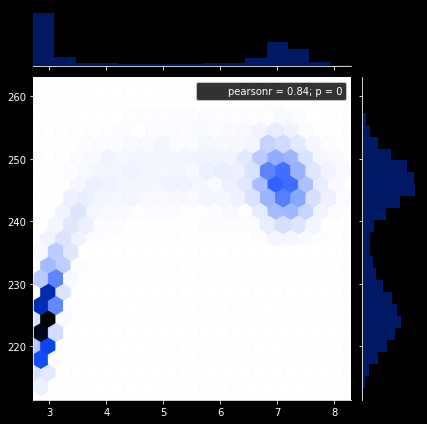

In [499]:
idx = np.random.choice(np.arange(sasa_ab_arr.flatten().shape[0]), 10000)

plt.figure(figsize=(12, 12))
sns.jointplot(x=com_dists.flatten()[idx], y=sasa_ab_arr.flatten()[idx], kind="hex")

# Build a classifier.

First of all, we need a classifier to distinguish between `associated` state vs `disassociated`. Let's find an emprircal distribution of SASA across all levels of force, repetitions and frames.

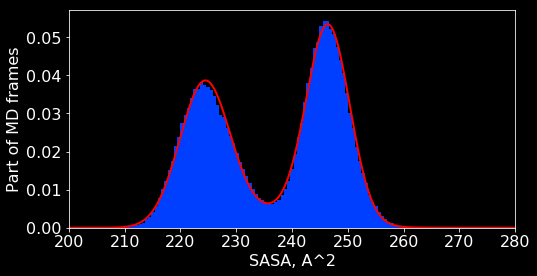

In [500]:
fig = plt.figure(figsize=(8, 4))

ax = fig.add_subplot(1, 1, 1)
ax.hist(sasa_ab_arr.flatten(), density=True, bins=100);
# ax.hist(com_dists.flatten(), density=True, bins=100);
ax.plot(x_plot, gauss(x_plot, *result.x), 'r-', lw=2)
ax.set_xlabel("SASA, A^2", fontdict={"size": 16})
ax.set_ylabel("Part of MD frames", fontdict={"size": 16})
ax.set_xlim(200, 280)
# ax.set_xlim(0, 10)

# for mix in mixtures:
#     sampled = np.array([mix.sample()[0] for _ in range(1000)])
#     sns.distplot(sampled[:, 0, 0], hist=False)

[t.set_fontsize(16) for t in ax.get_xticklabels()];
[t.set_fontsize(16) for t in ax.get_yticklabels()];

$$
P (class=c\ |\ X=x) = \frac{P(X=x\ |\ class=c) P (class=c)}{\sum_{i}P(X=x | class=i)}
$$

There are three states: `associated` (A), `intermediate` (I) and `disassociated` (D). We want to find boundaries between them. Let's find points where probability of A = probability of I.

$$
P(class = A\ |\ X=x) = P(class = I\ |\ X=x)
$$

$$
\frac{P(X=x\ |\ class=A) P (class=A)}{\sum_{i}P(X=x | class=i)} = \frac{P(X=x\ |\ class=I) P (class=I)}{\sum_{i}P(X=x | class=i)}
$$

$$
P(X=x\ |\ class=A) P (class=A) = P(X=x\ |\ class=I) P (class=I)
$$

As long as both distributions are gaussian.

$$
\frac{1}{\sqrt{2 \pi}\sigma_{A}} \exp{\frac{-(x-\mu_{A})^2}{2\sigma_{A}^2}} = \frac{1}{\sqrt{2 \pi}\sigma_{I}} \exp{\frac{-(x-\mu_{I})^2}{2\sigma_{I}^2}}
$$

$$
\frac{1}{\sigma_{A}} \exp{\frac{-(x-\mu_{A})^2}{2\sigma_{A}^2}} = \frac{1}{\sigma_{I}} \exp{\frac{-(x-\mu_{I})^2}{2\sigma_{I}^2}}
$$

$$
-\ln{\sigma_{A}} + \frac{-(x-\mu_{A})^2}{2\sigma_{A}^2} = -\ln{\sigma_{I}} + \frac{-(x-\mu_{I})^2}{2\sigma_{I}^2}
$$

Use solver (like Wolframalpha) to get the solution 

$$
x_{A \to I} = -\frac{\sqrt{\sigma_{A}^2 \sigma_{I}^2 (2(\sigma_{A}^2 - \sigma_{I}^2)ln(\sigma_{A}) - 2(\sigma_{A}^2 - \sigma_{I}^2)\ln(\sigma_{I})+(\mu_{A} - \mu_{I})^2)} - \sigma_{A}^2\mu_{I} + \sigma_{I}^2\mu_{A}}{\sigma_{A}^2 - \sigma_{I}^2}
$$

$$
x_{I \to D} = -\frac{\sqrt{\sigma_{I}^2 \sigma_{D}^2 (2(\sigma_{I}^2 - \sigma_{D}^2)ln(\sigma_{I}) - 2(\sigma_{I}^2 - \sigma_{D}^2)\ln(\sigma_{D})+(\mu_{I} - \mu_{D})^2)} - \sigma_{I}^2\mu_{D} + \sigma_{D}^2\mu_{I}}{\sigma_{I}^2 - \sigma_{D}^2}
$$

In [512]:
N_COMPONENTS = (len(result.x) + 1) // 3

means = result.x[:-N_COMPONENTS+1:2]
idx = np.argsort(means)
means = means[idx]
apriori = result.x[-N_COMPONENTS+1:]
apriori = np.concatenate([apriori, np.array([1 - apriori.sum()])])
apriori = apriori[idx]
stds = result.x[1:-N_COMPONENTS+1:2][idx]

s_A, s_I, s_D = stds**2
m_A, m_I, m_D = means

s_diff_1 = (s_A - s_I)
s_diff_2 = (s_I - s_D)
m_diff_1 = (m_A - m_I) ** 2
m_diff_2 = (m_I - m_D) ** 2

a_to_i = -(np.sqrt(s_A*s_I*(s_diff_1 * np.log(s_A / s_I) + m_diff_1 )) - s_A*m_I + s_I*m_A) / s_diff_1
i_to_d = -(np.sqrt(s_I*s_D*(s_diff_2 * np.log(s_I / s_D) + m_diff_2 )) - s_I*m_D + s_D*m_I) / s_diff_2

def classify(x_arr):
    result = np.zeros_like(x_arr, dtype=np.uint8)
    result[x_arr < a_to_i] = 0
    result[(x_arr >= a_to_i) & (x_arr < i_to_d)] = 1
    result[x_arr >= i_to_d] = 2
    return result

print(a_to_i, i_to_d)

226.041812471 237.72126263


In [593]:
sasa_classified = classify(sasa_ab_arr)
classified_strings = np.apply_along_axis(lambda v: "".join([str(vv) for vv in v]), 2, classified_)

AA_frame_idx = []
for rep in range(10):
    for force in range(7, 11):
        for match in re.finditer(r"(0+)(1+)0", classified_strings[rep, force]):
            AA_frame_idx.extend([(rep, force, i) for i in range(match.start(), match.end() - 1)])
            
AD_frame_idx = []
for rep in range(10):
    for force in range(7, 11):
        for match in re.finditer(r"(0+)(1+)2", classified_strings[rep, force]):
            AD_frame_idx.extend([(rep, force, i) for i in range(match.start(), match.end() - 1)])
            
AA_idx_1, AA_idx_2, AA_idx_3 = zip(*AA_frame_idx)
AA_arr = whole_arr[AA_idx_1, AA_idx_2, AA_idx_3]
AA_arr_mean = AA_arr.mean(axis=0)
AA_arr_freq = (AA_arr < .3).mean(axis=0)

AD_idx_1, AD_idx_2, AD_idx_3 = zip(*AD_frame_idx)
AD_arr = whole_arr[AD_idx_1, AD_idx_2, AD_idx_3]
AD_arr_mean = AD_arr.mean(axis=0)
AD_arr_freq = (AD_arr < .3).mean(axis=0)

In [732]:
comb_freq.max()

0.95868840085417795

In [733]:
n_1 = AA_arr_freq.shape[0]
n_2 = AD_arr_freq.shape[0]

comb_freq = (AA_arr_freq * n_1 + AD_arr_freq * n_2) / (n_1 + n_2)
z = (AA_arr_freq - AD_arr_freq) / np.sqrt(comb_freq * (1 - comb_freq) * (1 / n_1 + 1 / n_2))

/home/analytics/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide


/home/analytics/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/home/analytics/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


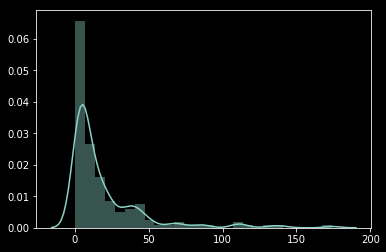

In [734]:
z_filt = z[z > 0]
sns.distplot(z_filt)

In [653]:
sorted_idx = np.argsort(z)
for i in [i for i in sorted_idx if ~np.isnan(z[i])][::-1]:
#     if z[i] > 8:
    print(get_pair(i), z[i])

(98, 152) 174.144434763
(99, 176) 140.348780586
(99, 152) 132.999662412
(91, 241) 114.137656905
(94, 226) 110.394140255
(127, 225) 109.619642406
(94, 228) 87.49868759
(94, 198) 85.8809078151
(57, 239) 76.3732716221
(66, 18) 68.3354834662
(102, 128) 67.9786832971
(59, 237) 65.6131197209
(44, 7) 56.0897518626
(45, 10) 49.5590441115
(65, 237) 49.5475033813
(74, 235) 48.8878136412
(102, 151) 46.9964179611
(47, 14) 45.7300134908
(60, 235) 43.100335412
(103, 103) 42.3190130633
(44, 5) 41.5501557891
(66, 16) 41.4567897507
(66, 39) 41.3528462809
(99, 199) 40.5502599064
(108, 11) 40.4445230443
(66, 14) 38.9899378708
(91, 228) 38.6088433026
(103, 127) 38.3100579036
(128, 225) 36.6911303292
(64, 83) 36.2294522257
(67, 235) 35.7393595919
(66, 40) 35.1751199308
(66, 5) 33.3263240146
(66, 37) 32.7130026165
(105, 12) 32.1811026954
(102, 152) 31.5172437149
(45, 8) 31.004009436
(66, 63) 27.4839312269
(105, 127) 26.4998676095
(104, 127) 24.95480002
(197, 11) 24.5855107891
(66, 19) 24.3179174556
(95, 226

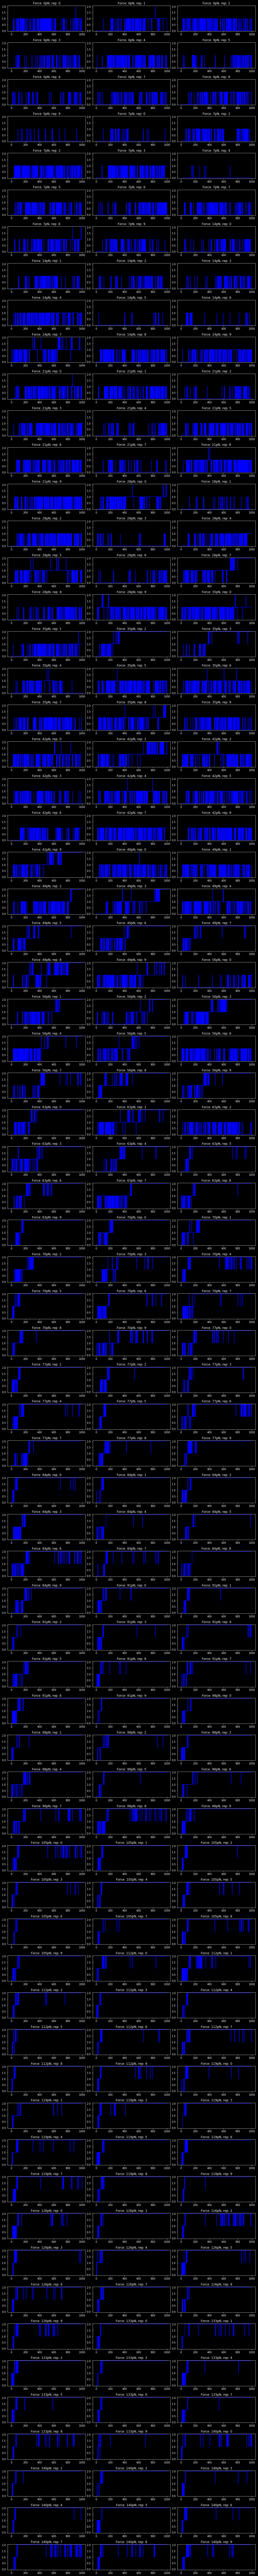

In [566]:
fig = plt.figure(figsize=(14, 140))
plt.style.use('dark_background')
fig.patch.set_facecolor("xkcd:black")
classified = get_classified(sasa_ab_arr, 1)

for f in range(21):
    for r in range(10):
        ax = fig.add_subplot(70, 3, f * 10 + r + 1)
        ax.plot(classified[r, f, :], "b-")
        ax.set_ylim(-0.05, 2.05)
        ax.set_title("Force: {}pN, rep: {}".format(f * 7, r))
        
plt.tight_layout()